In [1]:
# Set the default path to the data directory, here you can change to your own path
import os
default_path = r'C:\self-assembly-alldata'
os.chdir(default_path)

#Create a folder figures under the default path
if not os.path.exists('figures'):
    os.makedirs('figures')

# Self-Assembly Music - Synchronization Analysis

## 1. Sound Recording: Time and Frequency Signal

Definition for the plotting function to obtain the waveform and spectrogram from an audio recording

In [2]:
import numpy as np
import librosa.display
import matplotlib.pyplot as plt

# Plot the waveform and spectrogram for a given sound sample array and save the figures as pdf files
def plot_waveform_and_spectrogram(sound_samples, sr):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(sound_samples, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.xlim(left=0)
    plt.savefig('figures/waveform.pdf', bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.ylim(0, 2048)
    D = librosa.amplitude_to_db(librosa.stft(sound_samples, n_fft=2048, hop_length=512), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.savefig('figures/spectrogram.pdf', bbox_inches='tight')
    plt.show()

Plot the waveform and spectrogram for an audio recording

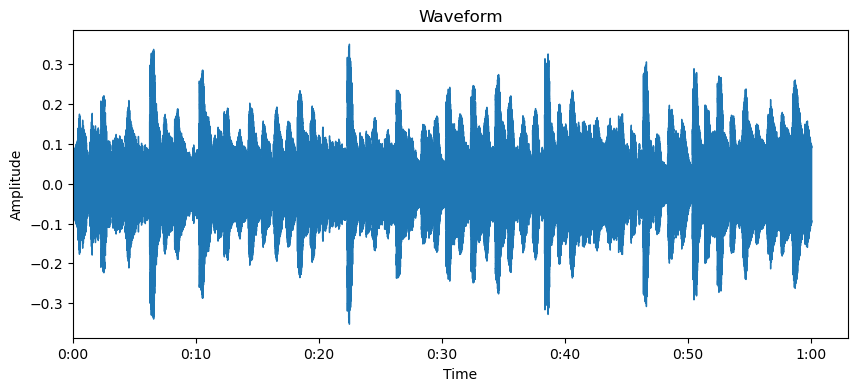

C:\Users\pitte\AppData\Local\Temp\ipykernel_30816\830838328.py:18: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(sound_samples, n_fft=2048, hop_length=512), ref=np.max)


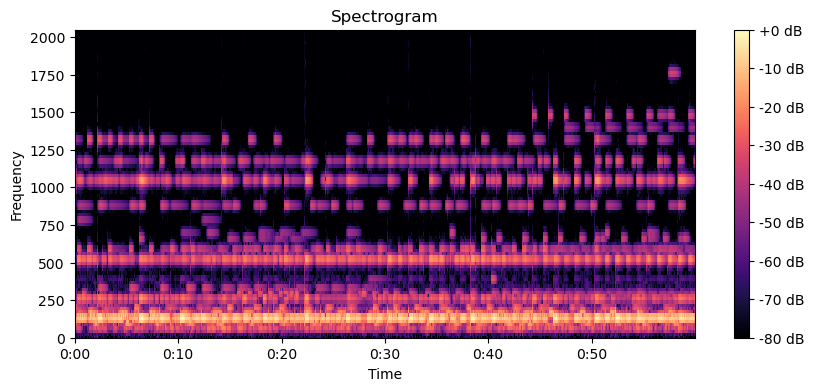

In [3]:
directory = "recordings" # We assume that the audio files are stored in the "recordings" directory under the current path
sr = 44100  # Sampling rate

def ShowPlots(file_name, sr):
    audio_file = file_name
    audio_path = directory + "\\" + audio_file
    audio_data, sr = librosa.load(audio_path, sr=sr)
    start_minute = 2 # The minute of the audio file to be plotted
    duration_minutes = 1 # The duration of the audio file to be plotted
    init_sample = 60 * sr * start_minute # Change here as you like
    end_sample = 60 * sr * (start_minute + duration_minutes) # Change here as you like
    plot_waveform_and_spectrogram(audio_data[init_sample:end_sample], sr)

ShowPlots("self-assembly-paper-audio.wav", sr)

## 2. Synchronization Analysis

### 2.1. Desynchronization Degree

This metric indicates in average how far an agent is from others in terms of their oscillators' phase. They are synchornized when this metric is approximately zero.

Functions for calculation and plotting:

In [4]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate the Desynchronization Degree per agent
def SyncErrorPerAgent(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)

    # Group the data by the "id" column
    grouped_data = df.groupby('id')

    # # Access each group
    agents_count = len(grouped_data)
    all_mean_differences = []

    for reference_group_name in range(1, agents_count + 1):
        reference_timestamps = grouped_data.get_group(reference_group_name)['time'].values
        mean_differences = []

        for reference_time in reference_timestamps:

            # Initialize an empty list to store the average distances
            min_distances_per_other_agent = []

            # Iterate over each group
            for group_name, group_data in grouped_data:
                if group_name == reference_group_name:
                    continue
                # Get the sample times in the current group
                sample_times = group_data['time']
                
                # Calculate the absolute differences between the first time and sample times
                min_abs_differences = np.abs(sample_times - reference_time).min()
                
                # Append the average distance to the list
                min_distances_per_other_agent.append(min_abs_differences)

            # Append the average distance to the list
            mean_differences.append(np.array(min_distances_per_other_agent).mean())

        #print(len(mean_differences))
        all_mean_differences.append(mean_differences)

    return all_mean_differences


# Function to plot the Desynchronization Degree per agent
def PlotSyncError(all_mean_differences, save_file = False, agents_size = 0, file_path_fig = 'figures/'):
    plt.figure(figsize=(10, 4))
    min_len = sys.maxsize
    for mean_differences in all_mean_differences:
        plt.plot(mean_differences)
        len_means = len(mean_differences)
        if len_means < min_len:
            min_len = len_means    

    
    # Set the labels for the x-axis and y-axis
    plt.xlabel('Time (s)')
    plt.ylabel('Desynchronization Degree (s)')

    # Set the title of the graph
    title = 'Desynchronization Degrees for '+str(agents_size)+' Agents over time'
    plt.title(title)
    
    if save_file:
        # Save the graph to a file
        plt.savefig(file_path_fig + title + '.pdf', bbox_inches='tight')

    plt.show()

### 2.1.1. Pre-calculation of desynchronization degree's files

As the calculation of the desynchronization degree may take a considerable amount of time (maybe a day), in order to plot later, we can save precalculated arrays as below (SET THE BOOLEAN PRECALCULATE TO TRUE TO EXECUTE)

In [5]:
#Generate sync error files
import os
import pickle

PRECALCULATE = False
if PRECALCULATE:
    directory = 'data/sync_struct_5_100/'
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.startswith("SYNC"): 
                file_path = os.path.join(root, file)
                all_mean_differences = SyncErrorPerAgent(file_path)
                file_path_diff = os.path.join(root, 'DIFF-' + file[:-4] + '.pkl')
                with open(file_path_diff, "wb") as file:
                    pickle.dump(all_mean_differences, file)

### 2.1.2. Plotting an example

Once having the pre-calculated files we can take one and plot the desynchronization degrees per agent as the next example

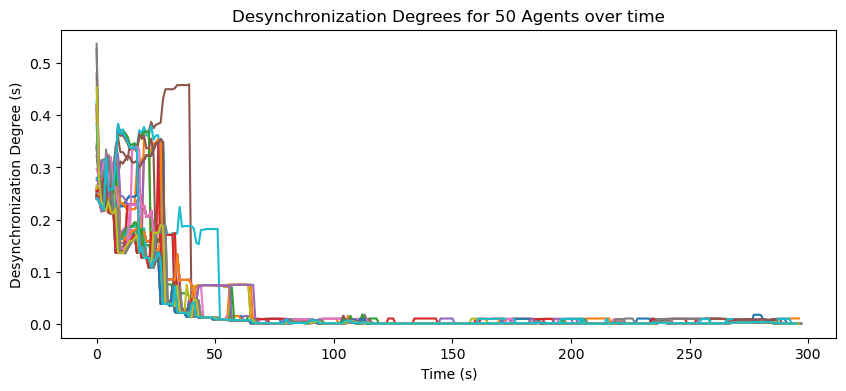

In [6]:
import pickle

# Specify the file path
file_path = "data/sync_struct_5_100/size-50-join-5/DIFF-SYNC-2024_05_05_09_14_52-N-50-ls-1-hs-1-wt-1-jt-5-jr-2-js-6-rb-2-f-1.pkl"

# Load the data from the file
with open(file_path, "rb") as file:
    sync_errors = pickle.load(file)

# Print the retrieved array
PlotSyncError(sync_errors, save_file = True, agents_size = 50, file_path_fig = 'figures/')

## 2.2. Synchronization time per number of agents

This metric indicates how much time in average a group of agents reach synchronization (zero desynchronization degree).

Functions for calculation and plotting:

In [7]:
import os

# Calculate the approximate synchronization time from the sync errors of an agent
def GetApproximateSyncTime(sync_errors):
    times = []
    threshold = 0.01 * 2 # twice deltatime
    agents_size = len(sync_errors)
    for t in range(0, 300):    
        counter = 0
        for sync_error_agent in sync_errors:
            if t < len(sync_error_agent) and sync_error_agent[t] <= threshold:
                counter += 1
            else:
                break
        if counter == agents_size:
            #print("All agents are synchronized at time: " + str(t))
            return t
        times.append(t)
    print("Threshold is too low, not all agents are synchronized: " + str(len(sync_errors)))
    return -1      


import pickle

# Process all the sync errors for a given number of agents from teh files in a folder (change the folder if needed)
def ProcessDiffSyncError(agents_size):
    folder_path = 'data/sync_struct_5_100/size-'+ str(agents_size)+'-join-5'
    file_names = [file for file in os.listdir(folder_path) if file.startswith('DIFF-SYNC')]
    sync_errors_agent = []
    unsync_runs = 0
    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, "rb") as file:
            sync_errors = pickle.load(file)
            syncTime = GetApproximateSyncTime(sync_errors)
            if syncTime < 0:
                unsync_runs += 1
            else:
                sync_errors_agent.append(syncTime)
    return sync_errors_agent, unsync_runs

Process different sizes for plotting afterwards. It is assumed that the pre-calculated desynchornization degree files exists (look above in 2.1.1)

In [8]:
agents_size_array = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
all_sync_errors = []
all_unsync_runs = []
for agents_size in agents_size_array:
    sync_errors_agent, unsync_runs = ProcessDiffSyncError(agents_size)
    all_sync_errors.append(sync_errors_agent)
    all_unsync_runs.append(unsync_runs)

Threshold is too low, not all agents are synchronized: 5
Threshold is too low, not all agents are synchronized: 10
Threshold is too low, not all agents are synchronized: 10
Threshold is too low, not all agents are synchronized: 10
Threshold is too low, not all agents are synchronized: 20
Threshold is too low, not all agents are synchronized: 20
Threshold is too low, not all agents are synchronized: 30


Plotting and show linear regression results

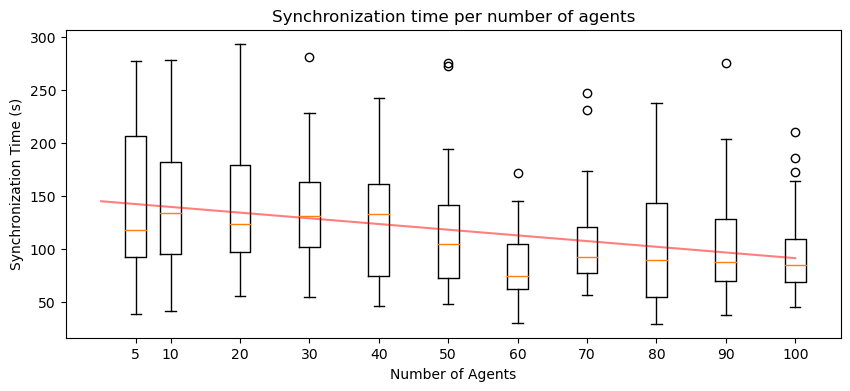

                            OLS Regression Results                            
Dep. Variable:            Sync Errors   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     29.45
Date:                Wed, 24 Jul 2024   Prob (F-statistic):           1.13e-07
Time:                        12:30:54   Log-Likelihood:                -1751.3
No. Observations:                 323   AIC:                             3507.
Df Residuals:                     321   BIC:                             3514.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        144.9248      5.933     24.425      0.0

In [9]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

def plot_all_sync_errors(all_sync_errors):
    # Create a list of data for each group in agents_size_array
    data = [all_sync_errors[i] for i in range(len(agents_size_array))]

    ### LINEAR REGRESSION
    
    # Create an empty DataFrame
    data_sync = pd.DataFrame()

    # Iterate over each collection in all_sync_errors
    for i, collection in enumerate(all_sync_errors):
        # Get the corresponding agent size from agents_size_array
        agent_size = agents_size_array[i]
        
        # Create a new DataFrame with the collection data
        df = pd.DataFrame(collection, columns=['Sync Errors'])
        
        # Add a new column for the agent size
        df['Agent Size'] = agent_size
        
        # Append the new DataFrame to the main dataset
        data_sync = pd.concat([data_sync, df], ignore_index=True)

    # Fit the linear regression model
    X = data_sync['Agent Size']
    y = data_sync['Sync Errors']
    X = sm.add_constant(X)  # Add a constant term to the predictor variable
    linear_model_sync = sm.OLS(y, X).fit()


    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 4))    

    # Create a boxplot
    ax.boxplot(data, positions=agents_size_array, widths=3)

    # Set the x-axis labels
    ax.set_xticklabels(agents_size_array)

    #plt.plot(X['Agent Size'], linear_model_sync.predict(X), color='red')

    # Set the x-axis label
    ax.set_xlabel('Number of Agents')

    # Set the y-axis label
    ax.set_ylabel('Synchronization Time (s)')

    title = 'Synchronization time per number of agents'
    # Set the title
    ax.set_title(title)

    # Plot linear_model_sync line
    x = np.linspace(0, 100, 100)
    y = linear_model_sync.params[0] + linear_model_sync.params[1] * x
    plt.plot(x, y, color='red', alpha=0.5)

    plt.savefig('figures/' + title + '.pdf', bbox_inches='tight')

    # Show the plot
    plt.show()

    # Print the summary of the linear regression model
    print(linear_model_sync.summary())

    # Print teh exact values of p values 
    print(linear_model_sync.pvalues)

plot_all_sync_errors(all_sync_errors)